In [1]:
# Sahana and Vikram
# Jan 25 2022
# Testing Quantum to make the real thing

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/Users/sidharthanantha/Documents/SciFair 2022/Quantum_test_data" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [4]:
from tqdm import tqdm
import os
import cv2
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
TRAIN_DIR = "/Users/sidharthanantha/Documents/SciFair 2022/Alzheimers_Dataset_V1/train"
TEST_DIR = "/Users/sidharthanantha/Documents/SciFair 2022/Alzheimers_Dataset_V1/test"
IMG_SIZE = 50 # experiment on this
LR = 1e-3
MODEL_NAME = "classifying_alzheimers_v1.model"
train_images = "train_images.txt"
test_images = "test_images.txt"

def label_img(folder):
    if folder == 'NonDemented': return 0
    elif folder == 'VeryMildDemented': return 1
    elif folder == 'MildDemented': return 2
    elif folder == 'ModerateDemented': return 3
    
def create_train_data():
    training_data = []
    for folder in tqdm(os.listdir(TRAIN_DIR), disable=True):
        label = label_img(folder)
        if folder == ".DS_Store": continue
        fol_path = os.path.join(TRAIN_DIR, folder)
        
        for img in tqdm(os.listdir(fol_path), disable=True):
            try:
                img_path = os.path.join(fol_path, img)

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                training_data.append([np.array(img), np.array(label)])
            except:
                continue
    shuffle(training_data)
    # print(training_data)
    # saving our trained data for further uses if required
    np.save('train_data.npy', training_data)
    return training_data

def process_test_data():
    test_data = []
    for folder in tqdm(os.listdir(TEST_DIR), disable=True):
        if folder == ".DS_Store": continue
        fol_path = os.path.join(TEST_DIR, folder)
        label = label_img(folder)
        for img in tqdm(os.listdir(fol_path), disable=True):
            try: 
                img_num = os.listdir(fol_path).index(img)
                img_path = os.path.join(fol_path, img)

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                test_data.append([np.array(img), np.array(label)])
            except:
                continue
                
    shuffle(test_data)
    # print(training_data)
    # saving our trained data for further uses if required
    np.save('test_data.npy', test_data)
    return test_data

train_data = create_train_data()
test_data = process_test_data()

train = train_data[:-500]
test = train_data[-500:]

train_images = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_labels = np.array([i[1] for i in train])
# because the data is formatted by [img, which category], that makes it so that
# x = img, and y = which category
test_images = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_labels = np.array([i[1] for i in test])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [5]:
# mnist_dataset = keras.datasets.cifar10.load_data()
# (train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
# train_images = np.array(train_images[..., tf.newaxis])
# test_images = np.array(test_images[..., tf.newaxis])

In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [7]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((IMG_SIZE//2, IMG_SIZE//2, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, IMG_SIZE, 2):
        for k in range(0, IMG_SIZE, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
#             print(image.shape)
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [8]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


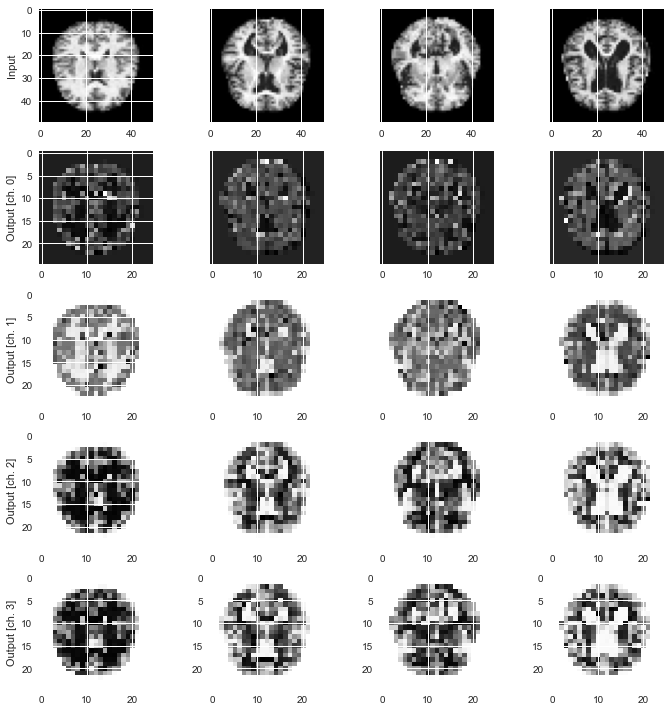

In [18]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [10]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [14]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 1.3556 - accuracy: 0.3400 - val_loss: 1.7083 - val_accuracy: 0.4333 - 425ms/epoch - 33ms/step
Epoch 2/30
13/13 - 0s - loss: 1.2527 - accuracy: 0.5400 - val_loss: 1.0795 - val_accuracy: 0.4667 - 52ms/epoch - 4ms/step
Epoch 3/30
13/13 - 0s - loss: 0.9055 - accuracy: 0.5800 - val_loss: 1.2698 - val_accuracy: 0.3667 - 60ms/epoch - 5ms/step
Epoch 4/30
13/13 - 0s - loss: 0.6950 - accuracy: 0.6400 - val_loss: 1.1000 - val_accuracy: 0.4333 - 71ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 0.5126 - accuracy: 0.8000 - val_loss: 1.3121 - val_accuracy: 0.5667 - 75ms/epoch - 6ms/step
Epoch 6/30
13/13 - 0s - loss: 0.4645 - accuracy: 0.8000 - val_loss: 1.1178 - val_accuracy: 0.4333 - 74ms/epoch - 6ms/step
Epoch 7/30
13/13 - 0s - loss: 0.3645 - accuracy: 0.9200 - val_loss: 1.0655 - val_accuracy: 0.5333 - 74ms/epoch - 6ms/step
Epoch 8/30
13/13 - 0s - loss: 0.2900 - accuracy: 0.9600 - val_loss: 1.1195 - val_accuracy: 0.4667 - 75ms/epoch - 6ms/step
Epoch 9/30
13/13 - 0s 

In [15]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 1.1822 - accuracy: 0.4800 - val_loss: 1.1671 - val_accuracy: 0.5333 - 419ms/epoch - 32ms/step
Epoch 2/30
13/13 - 0s - loss: 0.9979 - accuracy: 0.5800 - val_loss: 1.0135 - val_accuracy: 0.5333 - 67ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 0.9514 - accuracy: 0.5600 - val_loss: 1.0549 - val_accuracy: 0.4667 - 56ms/epoch - 4ms/step
Epoch 4/30
13/13 - 0s - loss: 0.9084 - accuracy: 0.5000 - val_loss: 1.0423 - val_accuracy: 0.5333 - 55ms/epoch - 4ms/step
Epoch 5/30
13/13 - 0s - loss: 0.8601 - accuracy: 0.5400 - val_loss: 1.0134 - val_accuracy: 0.5667 - 71ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 0.7782 - accuracy: 0.5600 - val_loss: 1.0741 - val_accuracy: 0.6000 - 68ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.7822 - accuracy: 0.6800 - val_loss: 1.0072 - val_accuracy: 0.5667 - 86ms/epoch - 7ms/step
Epoch 8/30
13/13 - 0s - loss: 0.7222 - accuracy: 0.6200 - val_loss: 1.1301 - val_accuracy: 0.2667 - 76ms/epoch - 6ms/step
Epoch 9/30
13/13 - 0s 

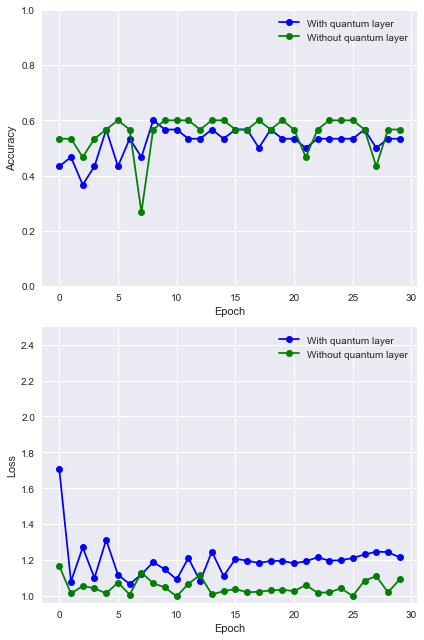

[0.4333333373069763, 0.46666666865348816, 0.36666667461395264, 0.4333333373069763, 0.5666666626930237, 0.4333333373069763, 0.5333333611488342, 0.46666666865348816, 0.6000000238418579, 0.5666666626930237, 0.5666666626930237, 0.5333333611488342, 0.5333333611488342, 0.5666666626930237, 0.5333333611488342, 0.5666666626930237, 0.5666666626930237, 0.5, 0.5666666626930237, 0.5333333611488342, 0.5333333611488342, 0.5, 0.5333333611488342, 0.5333333611488342, 0.5333333611488342, 0.5333333611488342, 0.5666666626930237, 0.5, 0.5333333611488342, 0.5333333611488342]


In [16]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
print(q_history.history["val_accuracy"])